In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from keras.models import load_model

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install --upgrade gdown

In [ ]:
!gdown 17Um12qRGVwCbDA-TLcUDAkymYssNsN2T

Downloading...
From: https://drive.google.com/uc?id=17Um12qRGVwCbDA-TLcUDAkymYssNsN2T
To: /content/FinalRatingsOver.csv
100% 3.08M/3.08M [00:00<00:00, 89.6MB/s]


In [ ]:
df = pd.read_csv('/content/FinalRatingsOver.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20602 entries, 0 to 20601
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  20602 non-null  object
 1   label   20602 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 322.0+ KB


In [ ]:
df.head()

,review,label
0,outlet great better dish servic yum garlic amb...,1
1,summer pay qualiti tax get realli time visit s...,0
2,varieti toastizza differ theyv burger mark the...,1
3,blue recommend cool sizzl qualiti could dazzl ...,1
4,dri realli stale month small meet unfortun pla...,1


In [ ]:
df.label.value_counts()

label
1    10301
0    10301
Name: count, dtype: int64

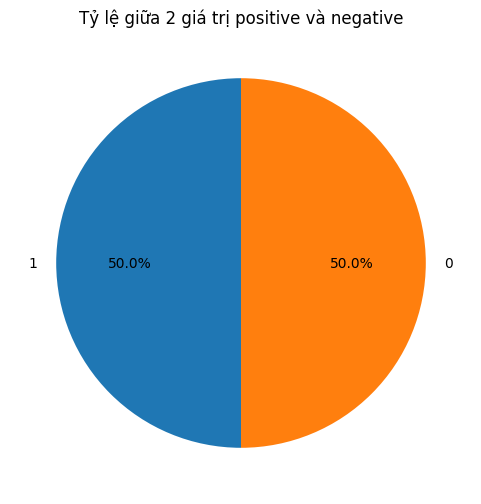

In [ ]:
value_counts = df.label.value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ giữa 2 giá trị positive và negative')
plt.show()

In [ ]:
print(df['review'].dtype)

object


# Build Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pickle as pkl
from sklearn.preprocessing import LabelEncoder

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, LayerNormalization, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
nltk.download('punkt')
def count_tokens(text):
    tokens = nltk.word_tokenize(text)
    return len(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df['token_count'] = df['review'].apply(count_tokens)

In [ ]:
df['token_count'].describe()

count    20602.000000
mean        24.275362
std         16.291414
min          1.000000
25%         14.000000
50%         20.000000
75%         31.000000
max         99.000000
Name: token_count, dtype: float64

In [ ]:
text = df['review'].values
label = df['label'].values

In [ ]:
label_tf = tf.keras.utils.to_categorical(label, num_classes=2, dtype='float32')

In [ ]:
maxlen_vector = 100
tokenizer_data = Tokenizer(oov_token='<OOV>', filters='', split=' ')
tokenizer_data.fit_on_texts(text)
tokenizer_data_text = tokenizer_data.texts_to_sequences(text)
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=maxlen_vector)

In [ ]:
pkl.dump(tokenizer_data, open('tokenizer_data.pkl', 'wb'))

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
print(f'Số quan sát tập train: {len(X_train)}')
# print(f'Số quan sát tập validation: {len(X_val)}')
print(f'Số quan sát tập test: {len(X_test)}')

Số quan sát tập train: 13184
Số quan sát tập validation: 4121
Số quan sát tập test: 3297


In [ ]:
data_vocab_size = len(tokenizer_data.word_index)+1
print(f'Vocab size: {data_vocab_size}')

Vocab size: 18192


In [ ]:
def model():
    dropout_threshold = 0.2
    initializer = tf.keras.initializers.GlorotNormal()
    input_layer = Input(shape=(maxlen_vector,))

    # Tạo Embedding để làm input layer
    feature = Embedding(input_dim=data_vocab_size, output_dim=32, input_length=maxlen_vector,
                        embeddings_initializer='GlorotNormal')(input_layer)

    # BiLSTM
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold,
                                         kernel_initializer=initializer))(feature)
    bi_lstm_feature = Dropout(dropout_threshold)(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Dense layer cho phân loại
    classifier = Dense(2, activation='softmax')(bi_lstm_feature)

    # Xây dựng mô hình cuối cùng
    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

In [ ]:
model = model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 32)           582144    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 layer_normalization (Layer  (None, 64)                128       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2)                 130   

In [ ]:
# fit model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_model = tf.keras.callbacks.ModelCheckpoint('BILSTM_model.h5',
                                                    monitor='val_loss')
history = model.fit(x=X_train, y=y_train, epochs=20, batch_size=128,
                    validation_split=0.1, callbacks=[callback_model])

model.fit(x=x_train,
          y=y_train,
          epochs=10,
          validation_data=(x_test, y_test),
          batch_size=32,
          callbacks=[tensorboard_callback])

Epoch 1/20
93/93 [==============================] - 22s 164ms/step - loss: 0.3575 - accuracy: 0.8418 - val_loss: 0.2003 - val_accuracy: 0.9212
Epoch 2/20
93/93 [==============================] - 16s 170ms/step - loss: 0.1329 - accuracy: 0.9531 - val_loss: 0.1959 - val_accuracy: 0.9287
Epoch 3/20
93/93 [==============================] - 8s 89ms/step - loss: 0.0820 - accuracy: 0.9743 - val_loss: 0.2105 - val_accuracy: 0.9310
Epoch 4/20
93/93 [==============================] - 9s 99ms/step - loss: 0.0548 - accuracy: 0.9839 - val_loss: 0.2263 - val_accuracy: 0.9303
Epoch 5/20
93/93 [==============================] - 5s 55ms/step - loss: 0.0400 - accuracy: 0.9860 - val_loss: 0.2990 - val_accuracy: 0.9166
Epoch 6/20
93/93 [==============================] - 4s 38ms/step - loss: 0.0350 - accuracy: 0.9881 - val_loss: 0.2962 - val_accuracy: 0.9234
Epoch 7/20
93/93 [==============================] - 3s 34ms/step - loss: 0.0251 - accuracy: 0.9917 - val_loss: 0.2952 - val_accuracy: 0.9242
Epoch 8/2

In [ ]:
%tensorboard --logdir logs/fit


In [ ]:
from nltk.tokenize import word_tokenize
def get_vectorize(input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(input))
    input_text_pre = ' '.join(input_text_pre)
    input_text_pre_accent = word_tokenize(input_text_pre)  # Sử dụng hàm word_tokenize() từ nltk.tokenize
    print(f'Input đã được xử lý là: {input_text_pre_accent}')
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=1500)
    return vec_data

def get_confidence(feature, model):
    label_dict = {'negative': 0, 'positive': 1}
    label = list(label_dict.keys())
    output = model(feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    return label[int(result)], conf

def get_prediction(input, tokenizer, model):
    input_model = get_vectorize(input, tokenizer)
    result, conf = get_confidence(input_model, model)
    return result, conf

model_using = load_model('/content/BILSTM_model (1).h5', compile=False)
with open('tokenizer_data.pkl', 'rb') as file:
    tokenizer_using = pkl.load(file)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels))

104/104 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1630
           1       0.97      0.89      0.93      1667

    accuracy                           0.93      3297
   macro avg       0.94      0.93      0.93      3297
weighted avg       0.94      0.93      0.93      3297



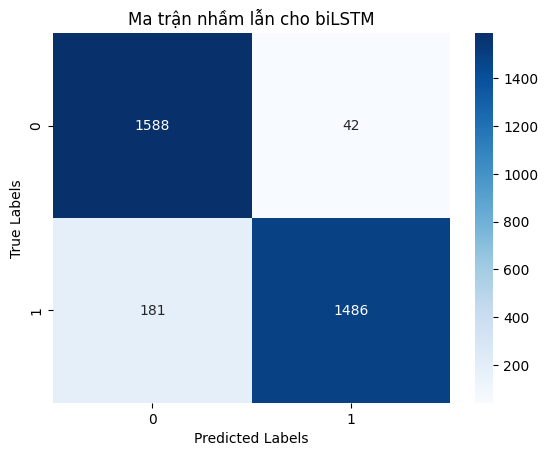

In [ ]:
le = LabelEncoder()
true_labels_encoded = le.fit_transform(y_true_labels)
predicted_labels_encoded = le.transform(y_pred_labels)

cm = confusion_matrix(true_labels_encoded, predicted_labels_encoded)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Ma trận nhầm lẫn cho biLSTM')
plt.show()